# Loan Approval Prediction Using Machine Learning

## Introduction

The goal of this project is to build a predictive model to determine whether a loan application should be approved. By analyzing historical loan data, we aim to identify key factors that influence loan approval decisions, which can help financial institutions make informed lending choices and manage risk effectively.


## Table of Contents

1. [Introduction](#Introduction)
2. [Importing Libraries](#Importing-Libraries)
3. [Loading the Data](#Loading-the-Data)
4. [Exploratory Data Analysis & Data Preprocessing](#Exploratory-Data-Analysis-&-Data-Preprocessing)
5. [Feature Scaling & Data Splitting](#Feature-Scaling-&-Data-Splitting)
6. [Model Selection (Training & Evaluation)](#Model-Selection-(Training-&-Evaluation))
7. [Model Interpretation](#Model-Interpretation)
8. [Conclusion](#Conclusion)

## Importing Libraries

This first import is used to ignore the warnings shown by the notebook, if you wish not to see them run the cell below. :)

In [134]:
# Handle warnings
import warnings
warnings.filterwarnings('ignore')

In [135]:
# Standard libraries
import os
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Machine learning libraries
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

## Loading the Data

I downloaded the data from <a href="https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data">Kaggle</a>. A relatively large dataset with good amount of features.

In [136]:
import pandas as pd

df = pd.read_csv('loan_data.csv')

df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


# Exploratory Data Analysis & Data Preprocessing

Let's begin by understanding the basic structure and properties of our dataset.

In [137]:
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

The dataset contains 45000 rows and 14 columns.


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

Here we can see which of our features are numeric and which are not. From here we can tell whether we have categorical features that we need to convert to numerical during preproccessing so we can train the model on that data as well.  
We can also see if we have any null values, so we can plan how to fill them or discard them.  
Here we can see we have 8 numeric features (excluding loan_status since it's our prediction target) and 5 categorical ones. We can also see that there are no records that have null for one of the values, so we don't need to discard or fill in any data.  

One thing I want to checkout first is what is the approved: rejected ratio among application in this dataset.

In [139]:
df['loan_status'].value_counts()

loan_status
0    35000
1    10000
Name: count, dtype: int64

Okay, so here we can see that our data isn't really balanced, there is a lot more rejections.

In [140]:
9948/44597

0.22306433168150325

So only about 22% of loan applications in this dataset were approved.  
This means we will need to balance our dataset, but let's leave that for the model training section.

In [141]:
# Statistical summary of numerical features
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


Alright let's go over the results and comment on what we can conclude from them.

 - majority of applicants are young adults, and by max being 144 we can tell we have a data entry error.
 - high standard deviation in person_income, which indicates large income variability, also max income seems extremely high and is very likely an outlier.
 - max work experience being 125 is an error, typical applicants have 1-8 years of experience.
 - typical loan amount is between \\$5000 and \\$12,237.
 - there are some extreme cases in loan to income ratio, like 0% and 66% that need checking.
 - most credit scores fall between 601 and 670 which is considered by banks to be somewhat risky.
 - loan_status having the mean of 0.22 indicates that only 22% of the loans were approved meaning this is a higly imbalanced dataset with more rejections.

Machine learning models are sensitive to anomalies and can perform poorly if they get trained on incorrect data. Let's clean up our data a bit!

In [142]:
df = df[(df['person_age'] >= 18) & (df['person_age'] <= 80)]

# Remove the applicants with income larger then 99th percentile
income_cap = df['person_income'].quantile(0.99)
df['person_income'] = df['person_income'].apply(lambda x: income_cap if x > income_cap else x)

# Make sure age - work_experience is at least 15 (minimum working age)
df = df[df['person_emp_exp'] <= (df['person_age'] - 15)]

# Set a realistic range for loan_percent_income
df = df[(df['loan_percent_income'] > 0.01) & (df['loan_percent_income'] <= 0.5)]

In [143]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,44597.000000,44597.000000,44597.000000,44597.000000,44597.000000,44597.000000,44597.000000,44597.000000,44597.000000
mean,27.728300,77428.283974,5.374509,9624.799291,11.011524,0.140229,5.853465,632.551674,0.223064
std,5.877499,44505.440897,5.893463,6295.893586,2.980924,0.085673,3.858713,50.374610,0.416306
min,20.000000,8000.000000,0.000000,500.000000,5.420000,0.020000,2.000000,390.000000,0.000000
25%,24.000000,47073.000000,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,66956.000000,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,94847.000000,8.000000,12250.000000,13.010000,0.190000,8.000000,670.000000,0.000000
max,80.000000,271268.200000,62.000000,35000.000000,20.000000,0.500000,30.000000,784.000000,1.000000


Alright, looks good now!  
We need to keep in mind that because only 22% of loans were approved the model might become biased, so Accuracy might not be a sufficient metric, we will also check precision, recall and F1-score.  
But that comes after we train the model, so let's move onto categorical features.

In [144]:
df.describe(include=['object'])

,person_gender,person_education,person_home_ownership,loan_intent,previous_loan_defaults_on_file
count,44597,44597,44597,44597,44597
unique,2,5,4,6,2
top,male,Bachelor,RENT,EDUCATION,Yes
freq,24602,13257,23324,9068,22626


From the summary above, we can derive several key insights:

- **Gender:** There are slightly more males than females among the applicants.

- **Education Level:** The most common education level among applicants is a Bachelor's degree.
  
- **Home Ownership:** The majority of applicants are renting their homes.
  
- **Loan Intent:** The most frequent purpose for loans is education.

These findings align with our earlier conclusion that most applicants are young adults who are in the early stages of their careers and financial journeys.

What's particularly interesting is that more than half of the applicants in our dataset have had previous loan defaults, meaning they were not able to pay back money they borrowed in the past. This would significantly worsen their credit scores and is a major red flag for banks when considering loan applications. This factor could explain why our dataset leans more towards loan rejections.

## Visualizing our data

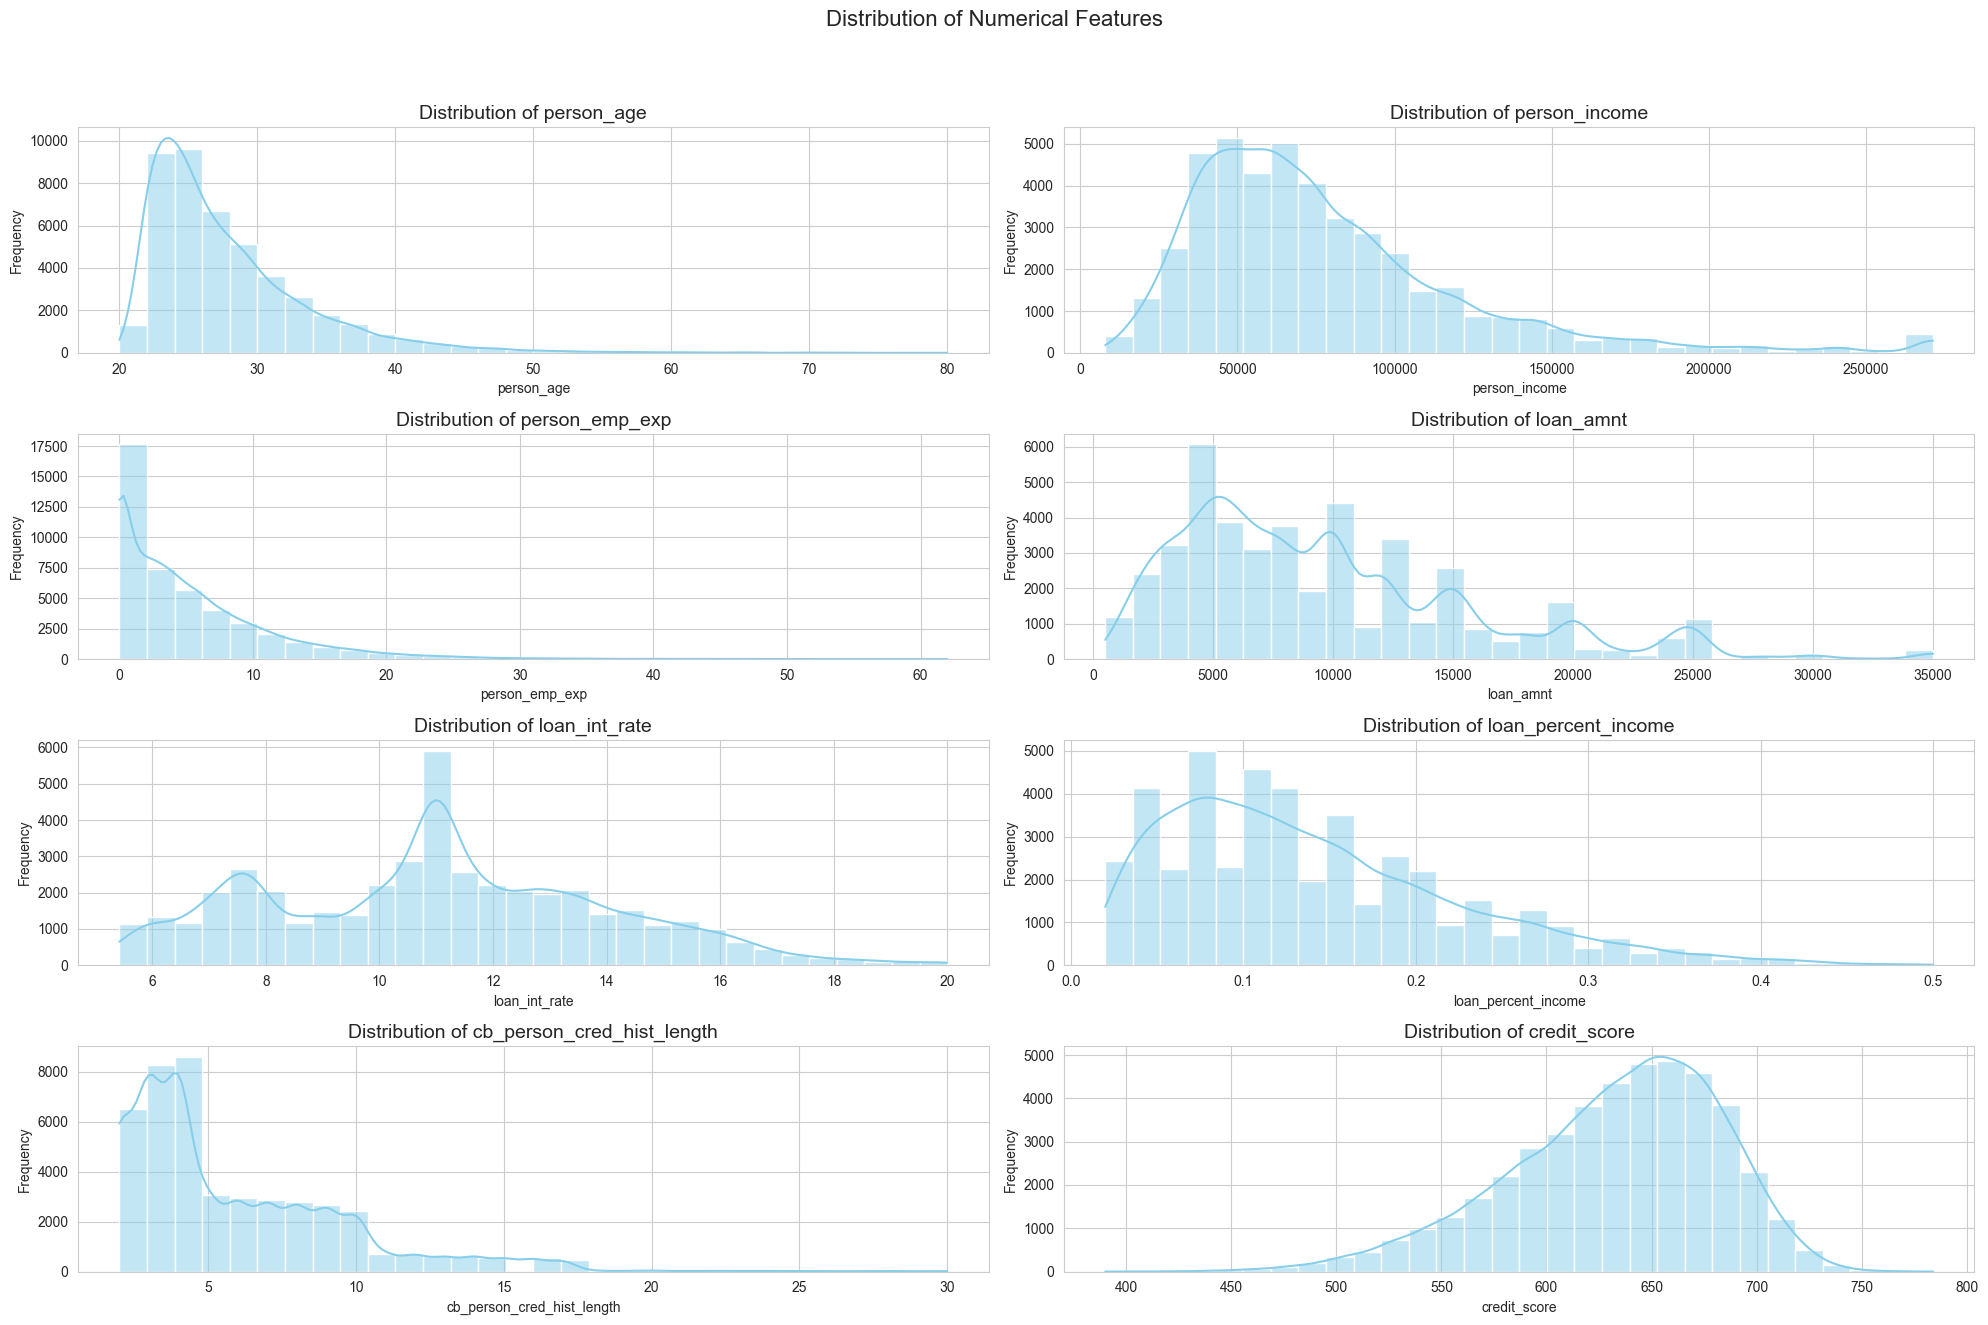

In [145]:
sns.set_style('whitegrid')

num_features = ['person_age', 'person_income', 'person_emp_exp',
                'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                'cb_person_cred_hist_length', 'credit_score']

fig, axes = plt.subplots(4, 2, figsize=(20, 15))
fig.suptitle('Distribution of Numerical Features', fontsize=16)

axes = axes.flatten()

for idx, feature in enumerate(num_features):
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'Distribution of {feature}', fontsize=14)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()


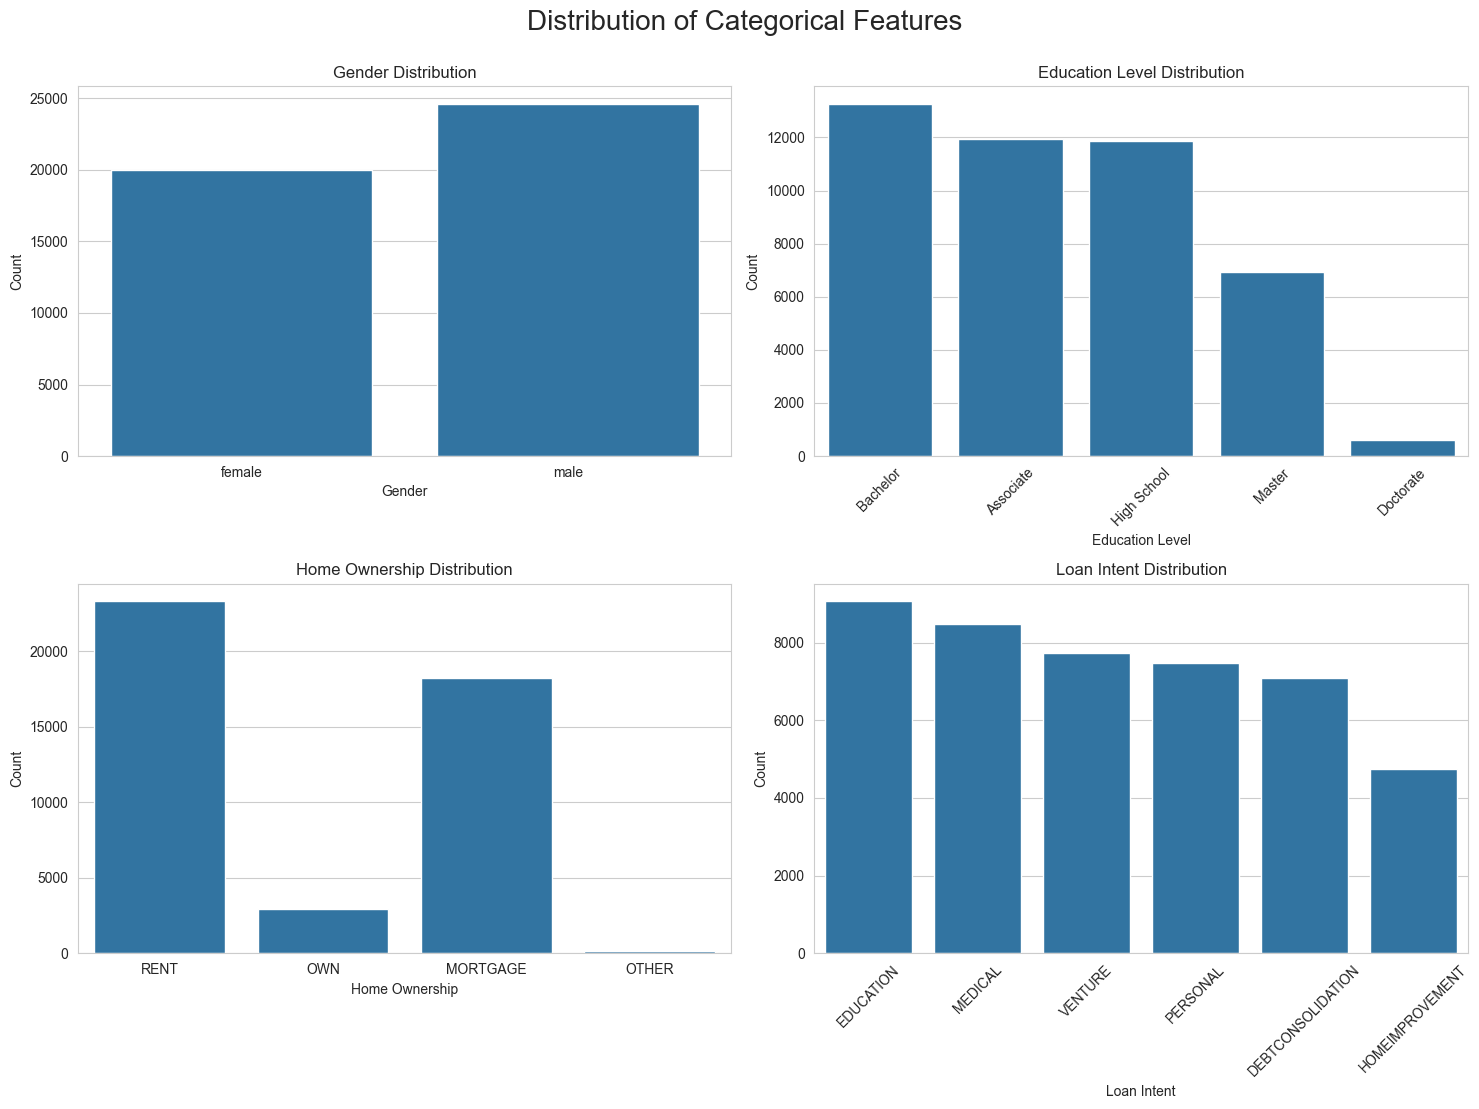

In [146]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution of Categorical Features', fontsize=20, y=0.95)

sns.countplot(x='person_gender', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Gender Distribution')
axes[0, 0].set_xlabel('Gender')
axes[0, 0].set_ylabel('Count')

sns.countplot(x='person_education', data=df, order=df['person_education'].value_counts().index, ax=axes[0, 1])
axes[0, 1].set_title('Education Level Distribution')
axes[0, 1].set_xlabel('Education Level')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.countplot(x='person_home_ownership', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Home Ownership Distribution')
axes[1, 0].set_xlabel('Home Ownership')
axes[1, 0].set_ylabel('Count')

sns.countplot(x='loan_intent', data=df, order=df['loan_intent'].value_counts().index, ax=axes[1, 1])
axes[1, 1].set_title('Loan Intent Distribution')
axes[1, 1].set_xlabel('Loan Intent')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

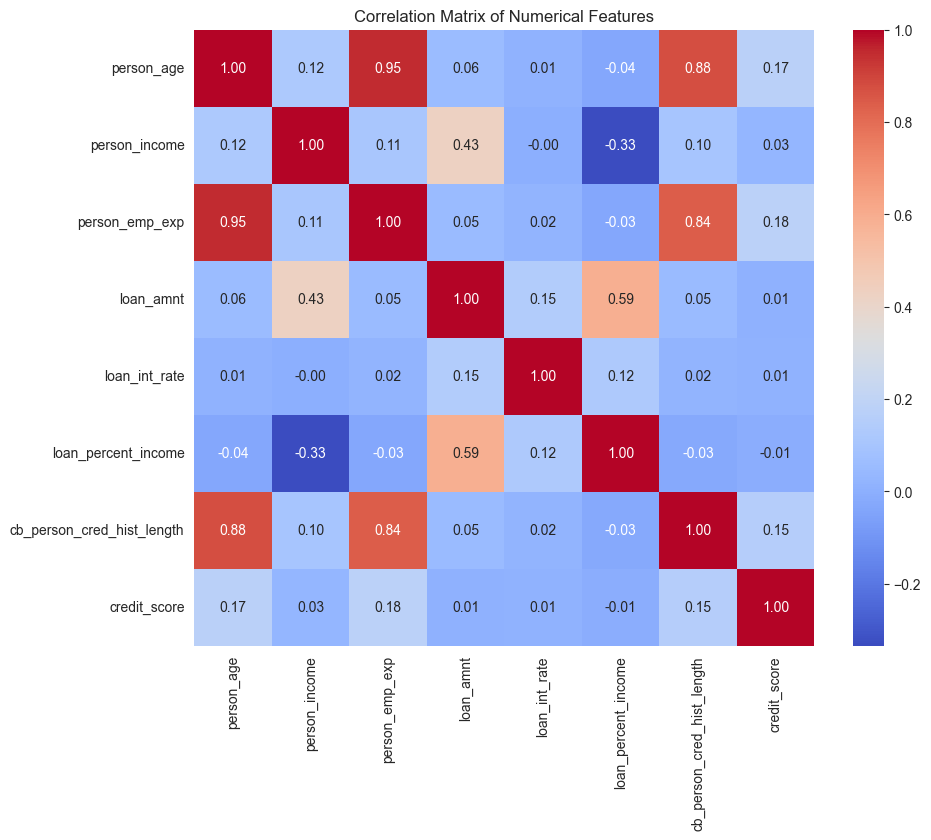

In [147]:
corr_matrix = df[num_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Okay, so the graphs nicely represent what we have already concluded before.  
From the heatmap we can see that age, work experience and credit history length, that is logical and needs no reading into.  
We can see that there is some correlation (0.43) with `person_income` and `loan_amnt`, generally, as income increases, the amount of loan requested also tends to increase.  
We observe a correlation of 0.59 between `loan_amnt` and `loan_percent_income`. This indicates that as the loan amount increases, it tends to form a higher percentage of the applicant's income. This relationship is important for understanding the financial strain on borrowers.  
We observe a negative correlation of -0.33 between `loan_percent_income` and `person_income`. This suggests that higher-income applicants typically request loans that constitute a smaller portion of their income, indicating lower financial strain


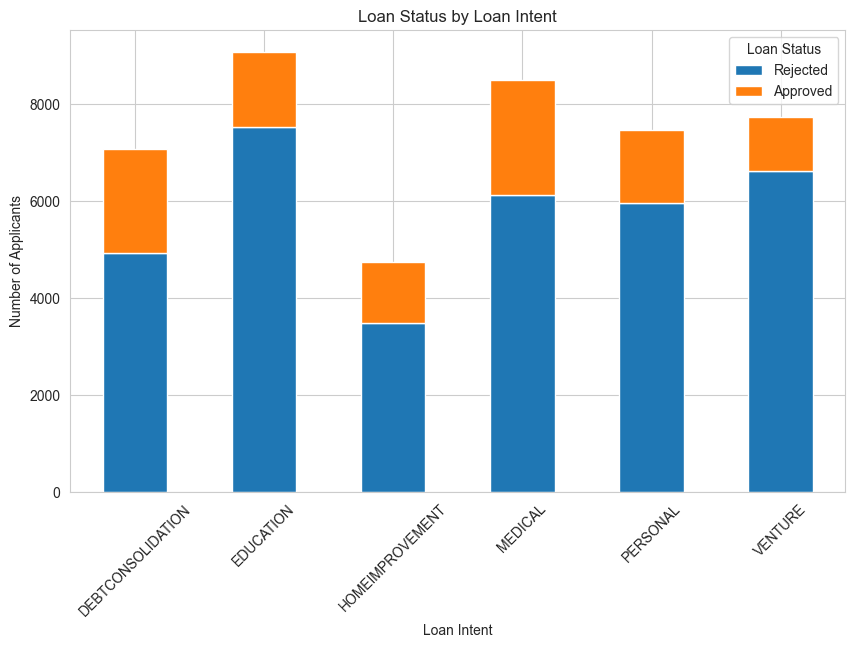

In [148]:
loan_status_counts = df.groupby(['loan_intent', 'loan_status']).size().unstack()

loan_status_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Loan Status by Loan Intent')
plt.xlabel('Loan Intent')
plt.ylabel('Number of Applicants')
plt.legend(title='Loan Status', labels=['Rejected', 'Approved'])
plt.xticks(rotation=45)
plt.show()

Here we can see that most loans are requested for education and medical purposes, but there is a fair amount of debt consolidation, personal and venture reasons.  
Home improvement is a significantly less common reason for taking out a loan, but seems to be more likely at getting approved.  
Debt consolidation and medical loans seem more likely to be approved then education and personal loans.  
Let's see these in percentagages so we can have a clearer view.

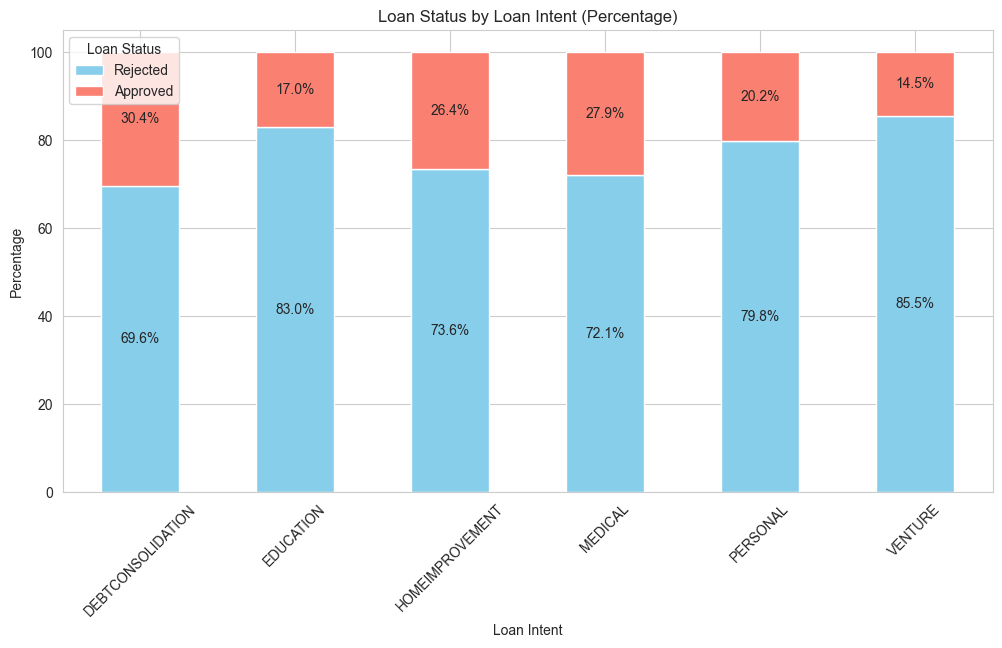

In [149]:
import pandas as pd
import matplotlib.pyplot as plt

loan_status_counts = df.groupby(['loan_intent', 'loan_status']).size().unstack()

loan_status_percentages = loan_status_counts.div(loan_status_counts.sum(axis=1), axis=0)*100

colors = ['skyblue', 'salmon']

ax = loan_status_percentages.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)
ax.set_title('Loan Status by Loan Intent (Percentage)')
ax.set_xlabel('Loan Intent')
ax.set_ylabel('Percentage')
ax.legend(title='Loan Status', labels=['Rejected', 'Approved'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center')

plt.xticks(rotation=45)
plt.show()

These confirm all our previous conclusions.

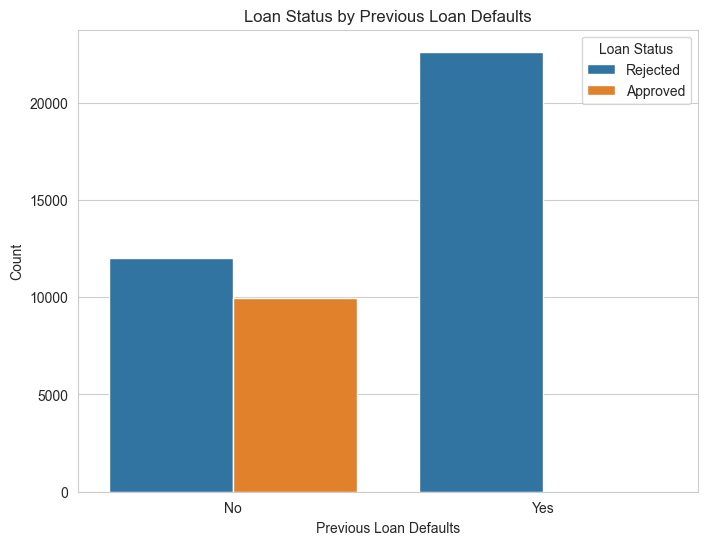

In [150]:
plt.figure(figsize=(8, 6))
sns.countplot(x='previous_loan_defaults_on_file', hue='loan_status', data=df)
plt.title('Loan Status by Previous Loan Defaults')
plt.xlabel('Previous Loan Defaults')
plt.ylabel('Count')
plt.legend(title='Loan Status', labels=['Rejected', 'Approved'])
plt.show()

This is really interesting, and aligns with what I said before about how significant defaults are, not a singe applicant who had a prevoius loan default got their loan approved.

To prepare our dataset for modeling, we need to convert categorical variables into numerical values our model can interpret.  
We have both nominal and ordinal categorical variables, ordinal are those where order matters, and for nominal ones it doesn't.  
Our only ordinal category is education level.

In [151]:
df = pd.get_dummies(df, columns=['person_gender'], drop_first=True)
df = pd.get_dummies(df, columns=['person_home_ownership'], drop_first=True)
df = pd.get_dummies(df, columns=['loan_intent'], drop_first=True)
df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].map({'No': 0, 'Yes': 1})


education_mapping = {
    'High School': 1,
    'Associate': 2,
    'Bachelor': 3,
    'Master': 4,
    'Doctorate': 5
}
df['person_education'] = df['person_education'].map(education_mapping)

In [152]:
# Let's see our new feature list (loan_status is the target)
print(df.columns.tolist())

['person_age', 'person_education', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file', 'loan_status', 'person_gender_male', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE']


## Feature Scaling & Data Splitting

To prepare the data for modeling, we need to scale the numerical features to ensure they are on a similar scale.

We only scale the features listed below because the one-hot encoded features we added in the previous step already have values of 0 and 1. The only exception from the categorical variables is `person_education`, which has values ranging from 1 through 5.

In [153]:
numeric_cols = ['person_age', 'person_education', 'person_income', 'person_emp_exp',
                'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                'cb_person_cred_hist_length', 'credit_score']

### Split the data before scalling

To prevent data leakage and ensure that our model generalizes well to new, unseen data, we split the dataset into training and testing sets before applying feature scaling. This way, the scaling parameters (mean and standard deviation) are learned only from the training data. We then apply the same transformation to the test data using these parameters.

In [154]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [155]:
scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

## Model Selection (Training & Evaluation)

### Logistic Regression

Logistic Regression is a linear classification algorithm commonly used for binary classification tasks. It models the probability that a given input belongs to a particular class using the logistic function. Logistic regression is suitable when the relationship between the independent variables and the target variable is approximately linear.

We set `max_iter` to 1000 to make sure the algorithm has enough time to converge.  
Setting `random_state` ensures reproducibility of results. Here we use number 42 (because it's the answer to the question of the Universe) but any other number will do.

In [156]:
logreg = LogisticRegression(max_iter=1000, random_state=42)

logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Decision Tree Classifier

Decision Tree Classifier is a non-parametric supervised learning method used for classification tasks.  
It works by recursively partitioning the data into subsets based on the value of input features. At each node in the tree, the algorithm selects the feature that yields the highest information gain (or the most significant reduction in impurity) to split the data.

In [157]:
dtree = DecisionTreeClassifier(random_state=42)

dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Random Forest Classifier

Random Forest Classifier is an ensemble learning method that builds multiple decision trees and merges their predictions to obtain a more accurate and stable result.  
It operates by constructing a multitude of decision trees during training time and outputting the class that is the mode of the classes (classification) of the individual trees.

`n_estimators` specifies the number of trees in the forest, a higher number of trees can improve model performance by reducing variance, but it also increases computational cost. We set it to 100, to balance between performance and computation time.

In [158]:
# n_jobs=-1 tells it to use all avaiable CPU cores, this way it is much faster
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

### Model Evaluation

 - Accuracy: calculates the accuracy score.
 - ROC AUC Score: useful for binary classification tasks to measure the model's ability to distinguish between classes.
 - Classification Report: includes precision, recall, F1-score, and support for each class.
 - Confusion Matrix: this matrix shows the counts of true positive, true negative, false positive, and false negative predictions.

In [159]:
def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # ROC AUC Score
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Classification Report
    class_report = classification_report(y_test, y_pred, target_names=['Rejected', 'Approved'])
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("Classification Report:")
    print(class_report)
    
    # Confusion Matrix Plot
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Rejected', 'Approved'],
                yticklabels=['Rejected', 'Approved'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()

### Logistic Regression Evaluation

Model: LogisticRegression
Accuracy: 0.8974
ROC AUC Score: 0.9545
Classification Report:
              precision    recall  f1-score   support

    Rejected       0.93      0.94      0.93      6930
    Approved       0.78      0.76      0.77      1990

    accuracy                           0.90      8920
   macro avg       0.85      0.85      0.85      8920
weighted avg       0.90      0.90      0.90      8920



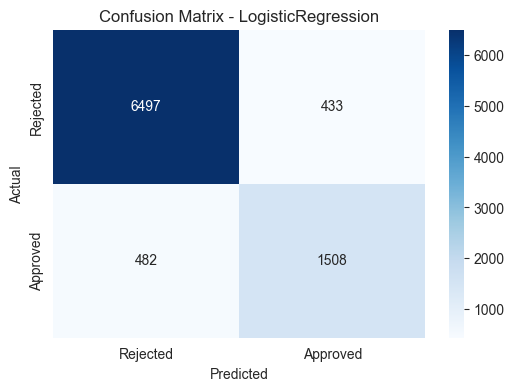

In [160]:
evaluate_model(logreg, X_test, y_test)

 - Accuracy indicates that the model correctly predicted the loan status in nearly 90% of the cases. But because the dataset is imbalanced (approx 7k rejected and 2k approved) we can't look at accuracy alone.
 - ROC AUC Score is 95.45%, it reflects the model's ability to distinguish between the approved and rejected classes. A score above 90% is excellent, suggesting the model effectively ranks positive instances higher than negative ones.

 - The model performs well in predicting rejected loans with high precision and recall.

 - For approved loans, the precision and recall are lower, indicating the model is less effective at identifying approvals. (probably because it has seen less approvals in training)

 - False Negatives (482 instances) are cases where approved loans were predicted as rejected, which may be critical depending on business priorities.

 - Class Imbalance: The dataset has more rejected loans (6,930) than approved loans (1,990), which can affect model performance for the minority class.

### Decision Tree Evaluation

Model: DecisionTreeClassifier
Accuracy: 0.8974
ROC AUC Score: 0.8548
Classification Report:
              precision    recall  f1-score   support

    Rejected       0.94      0.93      0.93      6930
    Approved       0.77      0.78      0.77      1990

    accuracy                           0.90      8920
   macro avg       0.85      0.85      0.85      8920
weighted avg       0.90      0.90      0.90      8920



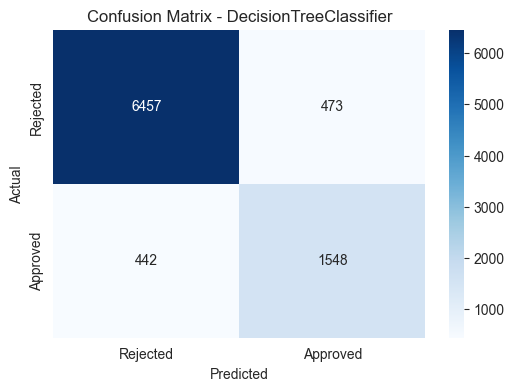

In [161]:
evaluate_model(dtree, X_test, y_test)

Scoreboard:
| Model        | Precision | Recall | F1-score |
|--------------|-----------|--------|----------|
| logreg       | 0.78      | 0.76   | 0.77     |
| dtree        |  0.77     | 0.78   | 0.77     |

Decision Tree results are pretty much the same. Let's try to improve it a bit!

In [162]:
dtree2 = DecisionTreeClassifier(
    max_depth=10,  # to prevent overfitting
    min_samples_split=50,
    random_state=42
)

dtree2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=50, random_state=42)

Model: DecisionTreeClassifier
Accuracy: 0.9213
ROC AUC Score: 0.9658
Classification Report:
              precision    recall  f1-score   support

    Rejected       0.93      0.97      0.95      6930
    Approved       0.88      0.75      0.81      1990

    accuracy                           0.92      8920
   macro avg       0.91      0.86      0.88      8920
weighted avg       0.92      0.92      0.92      8920



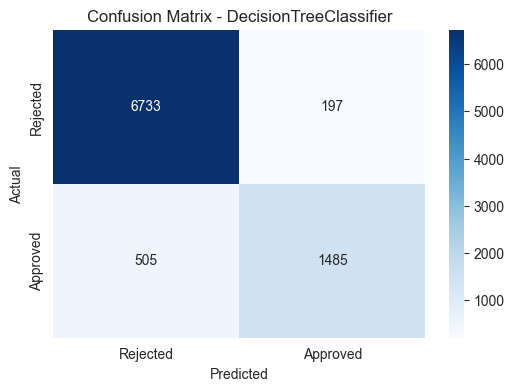

In [163]:
evaluate_model(dtree2, X_test, y_test)

Scoreboard:
| Model        | Precision | Recall | F1-score |
|--------------|-----------|--------|----------|
| logreg       | 0.78      | 0.76   | 0.77     |
| dtree        | 0.77      | 0.78   | 0.77     |
| dtree2       | 0.88      | 0.75   | 0.81     |

Alright, now we got quite a boost in precision, without a big decline in recall.

### Random Forest Evaluation

Model: RandomForestClassifier
Accuracy: 0.9296
ROC AUC Score: 0.9750
Classification Report:
              precision    recall  f1-score   support

    Rejected       0.94      0.97      0.96      6930
    Approved       0.90      0.77      0.83      1990

    accuracy                           0.93      8920
   macro avg       0.92      0.87      0.89      8920
weighted avg       0.93      0.93      0.93      8920



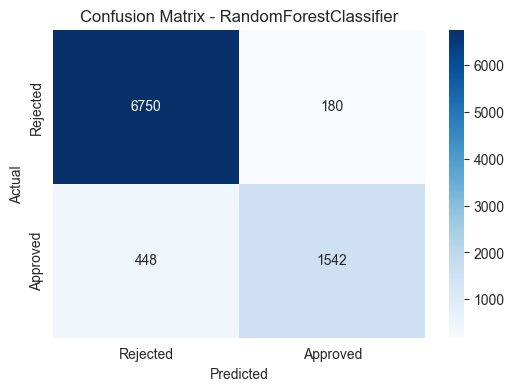

In [164]:
evaluate_model(rf, X_test, y_test)

Scoreboard:
| Model        | Precision | Recall | F1-score |
|--------------|-----------|--------|----------|
| logreg       | 0.78      | 0.76   | 0.77     |
| dtree        | 0.77      | 0.78   | 0.77     |
| dtree2       | 0.88      | 0.75   | 0.81     |
| randforest   | 0.90      | 0.77   | 0.83     |


Okay, so clearly Random Forest worked the best.  
Let's try to play around with Random Forest and our dataset to see can we make it even better.

In [165]:
y_train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {train_accuracy:.4f}')

Training Accuracy: 1.0000


In [166]:
y_test_pred = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9296


Since I tough the accuracy might be a bit to high, I wanted to check and make sure the model wasn't over fitting.  
Here we can see that the train accuaracy is 1.0 which is a clear indication it did infact overfit, let's try to fix that by limiting it's depth.

In [167]:
rf2 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

rf2.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

Model: RandomForestClassifier
Accuracy: 0.9244
ROC AUC Score: 0.9722
Classification Report:
              precision    recall  f1-score   support

    Rejected       0.93      0.98      0.95      6930
    Approved       0.91      0.74      0.81      1990

    accuracy                           0.92      8920
   macro avg       0.92      0.86      0.88      8920
weighted avg       0.92      0.92      0.92      8920



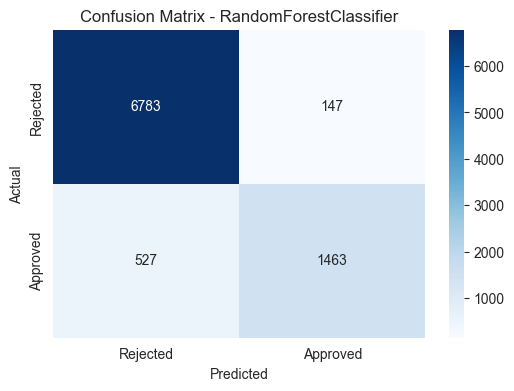

In [168]:
evaluate_model(rf2, X_test, y_test)

In [169]:
y_train_pred = rf2.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {train_accuracy:.4f}')

Training Accuracy: 0.9323


In [170]:
y_test_pred = rf2.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9244


Okay so the test accuaracy got only sligthly worse, by only 0.0052, and f1-score did drop by 0.02, but train and test accuracies are now way closer. Indicating that it no longer is overfitting.  
Let's try to do something about the model being biased towards rejecting loan applications.

### Balancing the dataset

It is possible that the model becomes biased towards rejecting loan applications only because it has seen disproportional amount of rejections in the train dataset. So let's now balance our dataset and try training the models again.

In [171]:
counter = Counter(y)
print("Before SMOTE:", counter)

n_rejected = counter[0]
n_approved_target = int(n_rejected * 0.5)

smote = SMOTE(sampling_strategy={1: n_approved_target}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

counter_resampled = Counter(y_resampled)
print("After SMOTE:", counter_resampled)

df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced['loan_status'] = y_resampled

Before SMOTE: Counter({0: 34649, 1: 9948})
After SMOTE: Counter({0: 34649, 1: 17324})


In [172]:
df_balanced

,person_age,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,person_gender_male,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_status
0,22.000000,4,71948.000000,0,35000.000000,16.020000,0.490000,3.000000,561,0,False,False,False,True,False,False,False,True,False,1
1,21.000000,1,12282.000000,0,1000.000000,11.140000,0.080000,2.000000,504,1,False,False,True,False,True,False,False,False,False,0
2,25.000000,1,12438.000000,3,5500.000000,12.870000,0.440000,3.000000,635,0,False,False,False,False,False,False,True,False,False,1
3,23.000000,3,79753.000000,0,35000.000000,15.230000,0.440000,2.000000,675,0,False,False,False,True,False,False,True,False,False,1
4,21.000000,1,12951.000000,0,2500.000000,7.140000,0.190000,2.000000,532,0,False,False,True,False,False,False,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51968,24.721711,1,36866.700988,5,17000.000000,12.350855,0.463609,2.639145,670,0,False,False,False,True,False,True,False,False,False,1
51969,23.641565,1,36965.358435,0,12044.804388,8.121511,0.321792,3.179218,525,0,True,False,False,True,True,True,False,False,False,1
51970,23.236013,2,49464.697666,1,9505.900333,14.519918,0.190590,4.295017,643,0,True,False,False,True,False,True,True,False,False,1
51971,22.281665,2,24197.761757,0,8000.000000,15.980169,0.330000,3.093888,665,0,True,False,False,True,False,True,False,False,False,1


In [173]:
df_balanced['loan_status'].value_counts()

loan_status
0    34649
1    17324
Name: count, dtype: int64

In [174]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

scaler = StandardScaler()

X_train_b[numeric_cols] = scaler.fit_transform(X_train_b[numeric_cols])

X_test_b[numeric_cols] = scaler.transform(X_test_b[numeric_cols])

In [175]:
y_train_b.value_counts(), y_test_b.value_counts()

(loan_status
 0    27719
 1    13859
 Name: count, dtype: int64,
 loan_status
 0    6930
 1    3465
 Name: count, dtype: int64)

In [176]:
logreg_b = LogisticRegression(max_iter=1000, random_state=42)

logreg_b.fit(X_train_b, y_train_b)

LogisticRegression(max_iter=1000, random_state=42)

Model: LogisticRegression
Accuracy: 0.8884
ROC AUC Score: 0.9601
Classification Report:
              precision    recall  f1-score   support

    Rejected       0.93      0.90      0.92      6930
    Approved       0.82      0.86      0.84      3465

    accuracy                           0.89     10395
   macro avg       0.87      0.88      0.88     10395
weighted avg       0.89      0.89      0.89     10395



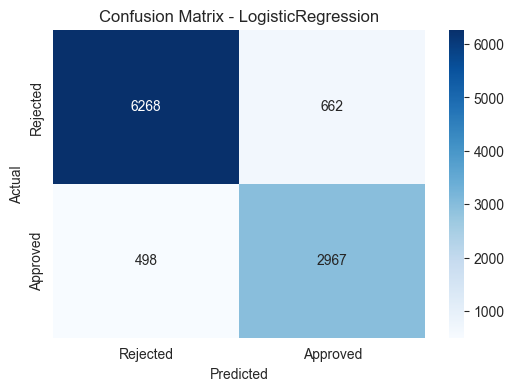

In [177]:
evaluate_model(logreg_b, X_test_b, y_test_b)

In [178]:
dtree2_b = DecisionTreeClassifier(
    max_depth=10,  # to prevent overfitting
    min_samples_split=50,
    random_state=42
)

dtree2_b.fit(X_train_b, y_train_b)

DecisionTreeClassifier(max_depth=10, min_samples_split=50, random_state=42)

Model: DecisionTreeClassifier
Accuracy: 0.9081
ROC AUC Score: 0.9712
Classification Report:
              precision    recall  f1-score   support

    Rejected       0.91      0.95      0.93      6930
    Approved       0.90      0.82      0.86      3465

    accuracy                           0.91     10395
   macro avg       0.91      0.89      0.89     10395
weighted avg       0.91      0.91      0.91     10395



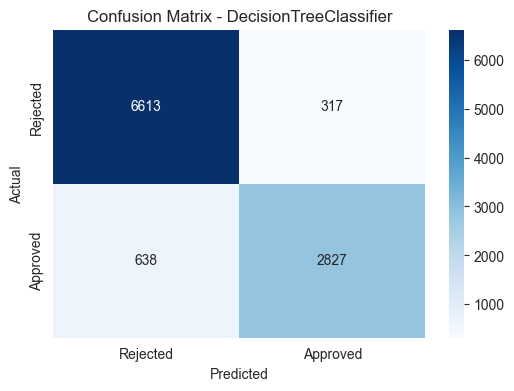

In [179]:
evaluate_model(dtree2_b, X_test_b, y_test_b)

In [180]:
rf2_b = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

rf2_b.fit(X_train_b, y_train_b)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

Model: RandomForestClassifier
Accuracy: 0.9207
ROC AUC Score: 0.9774
Classification Report:
              precision    recall  f1-score   support

    Rejected       0.92      0.96      0.94      6930
    Approved       0.91      0.84      0.88      3465

    accuracy                           0.92     10395
   macro avg       0.92      0.90      0.91     10395
weighted avg       0.92      0.92      0.92     10395



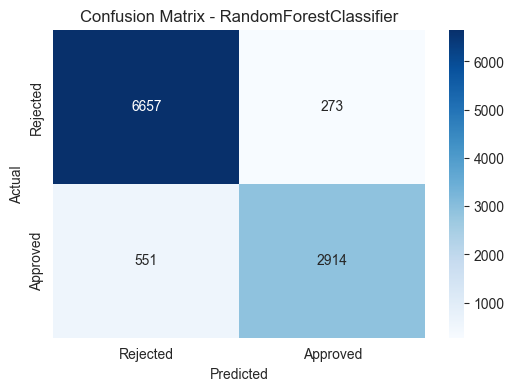

In [181]:
evaluate_model(rf2_b, X_test_b, y_test_b)

Scoreboard (BALANCED):

| Model        | Precision | Recall | F1-score |
|--------------|-----------|--------|----------|         
| logreg       | 0.82      | 0.86   | 0.84     |
| dectree      | 0.90      | 0.82   | 0.86     |
| randforest   | 0.91      | 0.84   |  0.88    |

Alright, so the Random Forest model still wins, let's try it on the actual unbalanced test dataset.

Model: RandomForestClassifier
Accuracy: 0.9176
ROC AUC Score: 0.9670
Classification Report:
              precision    recall  f1-score   support

    Rejected       0.95      0.94      0.95      6930
    Approved       0.81      0.83      0.82      1990

    accuracy                           0.92      8920
   macro avg       0.88      0.89      0.88      8920
weighted avg       0.92      0.92      0.92      8920



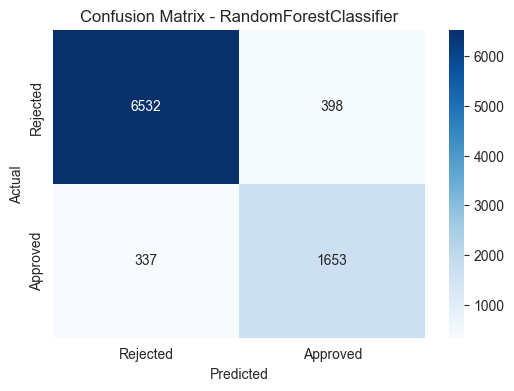

In [182]:
evaluate_model(rf2_b, X_test, y_test)

Model: RandomForestClassifier
Accuracy: 0.9296
ROC AUC Score: 0.9750
Classification Report:
              precision    recall  f1-score   support

    Rejected       0.94      0.97      0.96      6930
    Approved       0.90      0.77      0.83      1990

    accuracy                           0.93      8920
   macro avg       0.92      0.87      0.89      8920
weighted avg       0.93      0.93      0.93      8920



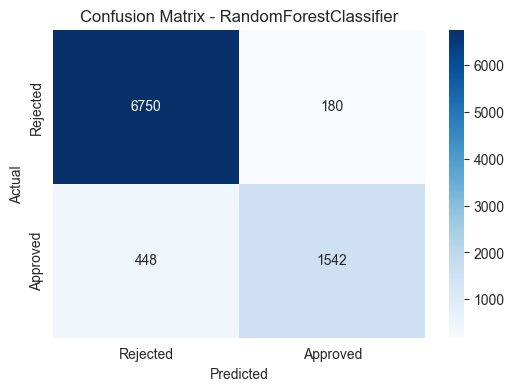

In [183]:
evaluate_model(rf, X_test, y_test)

Looks like the Random Forest model did better when tested on the actual unbalanced data!

## Model Interpretation

Let's see which of the features were most influental on our Random Forest model.

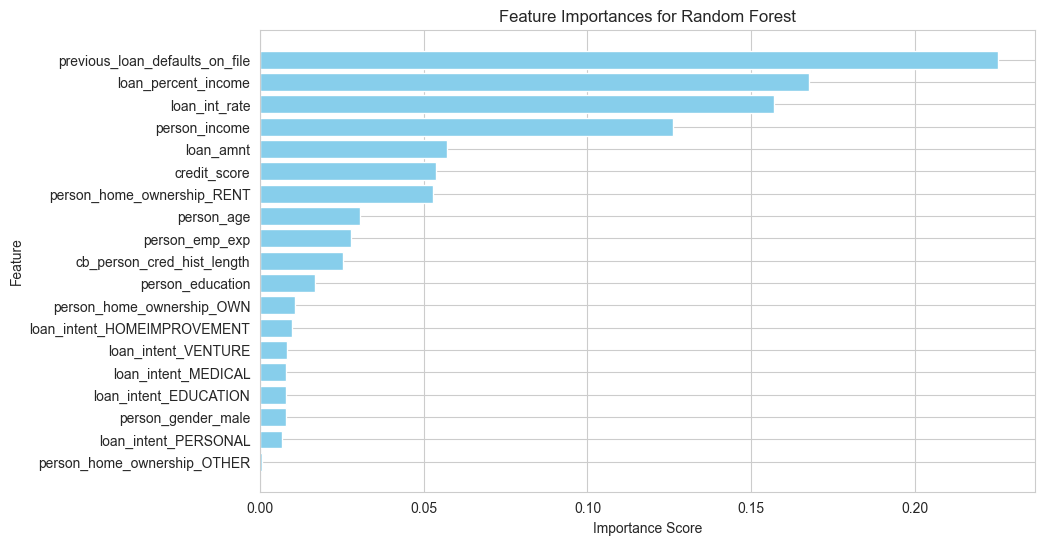

In [184]:
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

Sure enough having previous defaults was the most deciding feature, but loan to income ration, loan interest rates, as well as person's income were also quite influental.

## Conclusion

In this project, we built a machine learning model to predict whether a loan request should be approved or rejected. We experimented with multiple models and found that Random Forest performed the best. This was expected, as Random Forest is generally robust to both balanced and imbalanced datasets.  

We also explored the impact of balancing the dataset. While balancing improved model performance, the improvement was mainly observed on the balanced dataset itself. There is still room for further optimization, such as tuning hyperparameters, exploring different balancing techniques, or trying alternative models.